### Installs

In [1]:
# pip install seaborn
# pip install numpy==1.23.5
# pip install gym
# pip install scikit-learn
# python version: 3.9.6

### Imports

In [23]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.stats import mode
import seaborn as sns
from collections import defaultdict
import copy 
import matplotlib.animation as animation
import math
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning


In [44]:
# Functions
def distributionOfData(data):
    # Define bins
    bin_edges = np.arange(0, 11, 1)  # Bin edges at integer intervals (-4 to 4)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Create the histogram
    plt.hist(data, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7, label="Data Distribution")

    # Add labels and title
    plt.xlabel('Value Ranges (Standard Deviations)', fontsize=12)
    plt.ylabel('Frequency (Count of Data Points)', fontsize=12)
    plt.title('Histogram of Randomly Generated Data', fontsize=14)

    # Set x-axis ticks at bin centers
    plt.xticks(bin_centers, labels=[f"{x}" for x in bin_edges[:-1]])

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

def showDigitsData(X_data, y_data):
    # Print data
    print("Example of Data:")

    plt.imshow(X_data[0].reshape(8, 8), cmap="gray")
    plt.title(f"Example Image (Label: {y_data[0]})")
    plt.show()

def showNumericalDigitsData(digits):
    for i in range(3):
        print(f"Y-value: {digits.target[i]}")
        print(f"X-Value: {digits.data[i]}\n")

def filteredDigits():
        # Load the digits dataset
    digits = load_digits()

    # Extract the labels (target) from the dataset
    y = digits.target

    # Use np.where to find the indices of labels that are less than 5
    indices_less_than_5 = np.where(y < 5)
    
    return digits.data[indices_less_than_5], digits.target[indices_less_than_5], 

def allDigits():
    digits = load_digits()
    return digits.data, digits.target
    



In [45]:
X_data, y_data = filteredDigits()
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_test, y_test = allDigits()
print(f"Length of training data: {len(X_train)}")
print(f"Length of testing data: {len(X_test)}")


Length of training data: 720
Length of testing data: 1797


In [46]:
# Functions
def supervisedModel(X_train, X_test, y_test, y_train, epochs=10, batch_size=64):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    # Scale data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define MLP model (warm_start=True allows incremental training)
    model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1, warm_start=True, verbose=False, batch_size=batch_size)

    # Lists to store accuracy values
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in range(epochs):

        model.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")
    return model, train_accuracies, test_accuracies

def graphAccuracies(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)  # Create an epoch range
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(epochs, test_accuracies, label="Testing Accuracy", marker='s')
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Testing Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

def showCorrectPredictions(model, X_test, y_test):
    model_preds = model.predict(X_test)
    correct_indices = np.where(model_preds == y_test)[0][:10]  # Select 10 correctly classified digits

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_test[correct_indices[i]].reshape(8, 8), cmap='gray')
        ax.set_title(f"Pred: {model_preds[correct_indices[i]]}, True: {y_test[correct_indices[i]]}")
        ax.axis('off')
    plt.show()

def showIncorrectPredictions(model, X_test, y_test):
    model_preds = model.predict(X_test)
    incorrect_indices = np.where(model_preds != y_test)[0][:10]  # Select 10 correctly classified digits

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_test[incorrect_indices[i]].reshape(8, 8), cmap='gray')
        ax.set_title(f"Pred: {model_preds[incorrect_indices[i]]}, True: {y_test[incorrect_indices[i]]}")
        ax.axis('off')
    plt.show()

def showFeatureImportance(model, X_test, y_test):
    
    # Assuming 'model' is your trained MLPClassifier model
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Get the feature importances
    importances = result.importances_mean

    norm_importances = (importances - np.min(importances)) / (np.max(importances) - np.min(importances))

    importance_matrix = norm_importances.reshape(8, 8)
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(importance_matrix, cmap='Blues')  # Using the Blues colormap

    # Add colorbar to the plot
    fig.colorbar(cax)

    # Set axis labels (just for clarity, with indices 1 to 8 for both X and Y)
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(1, 9))
    ax.set_yticklabels(np.arange(1, 9))

    # Set title
    ax.set_title("Feature Importance Heatmap (Permutation Importance)")

    # Show the plot
    plt.show()

Epoch 1/10 - Training Accuracy: 0.3486, Testing Accuracy: 0.1775
Epoch 2/10 - Training Accuracy: 0.5333, Testing Accuracy: 0.2688
Epoch 3/10 - Training Accuracy: 0.7194, Testing Accuracy: 0.3561
Epoch 4/10 - Training Accuracy: 0.8472, Testing Accuracy: 0.4213
Epoch 5/10 - Training Accuracy: 0.9125, Testing Accuracy: 0.4558
Epoch 6/10 - Training Accuracy: 0.9417, Testing Accuracy: 0.4691
Epoch 7/10 - Training Accuracy: 0.9542, Testing Accuracy: 0.4769
Epoch 8/10 - Training Accuracy: 0.9625, Testing Accuracy: 0.4819
Epoch 9/10 - Training Accuracy: 0.9694, Testing Accuracy: 0.4864
Epoch 10/10 - Training Accuracy: 0.9778, Testing Accuracy: 0.4903


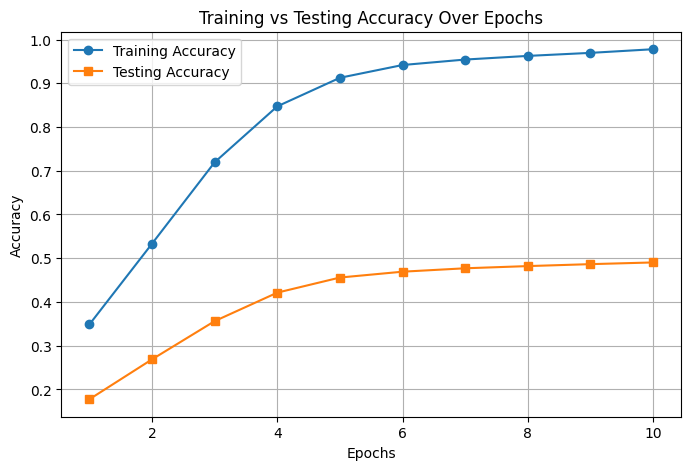

In [47]:
model, train_accuracies, test_accuracies = supervisedModel(X_train, X_test, y_test, y_train, epochs=10, batch_size=500)
graphAccuracies(train_accuracies, test_accuracies)

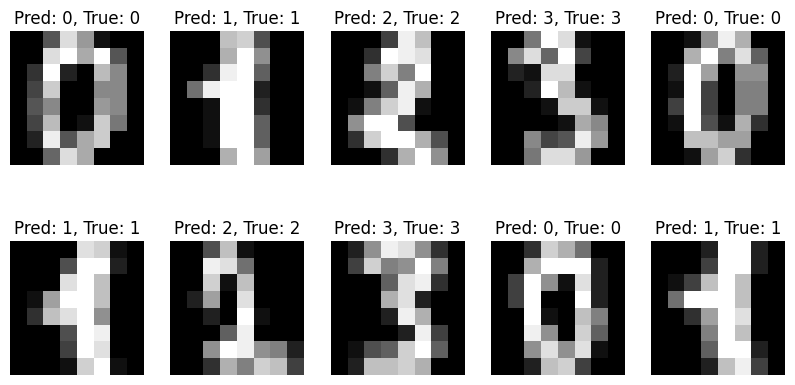

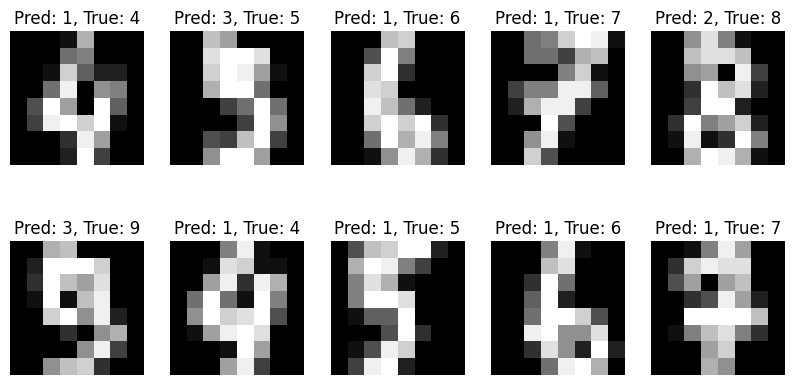

In [42]:
showCorrectPredictions(model, X_test, y_test)
showIncorrectPredictions(model, X_test, y_test)

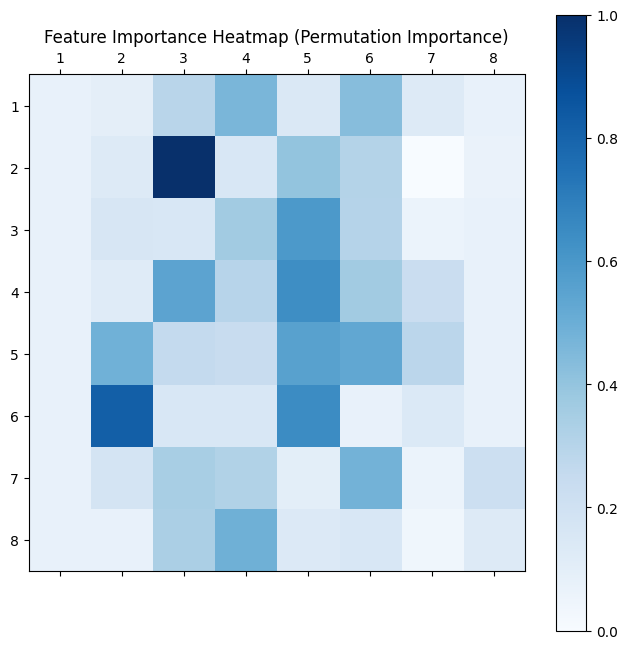

In [43]:
showFeatureImportance(model, X_test, y_test)

### Reinforcement Learning

In [41]:
def reinforcement_learning():
    ACTION_MAP = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="ansi")
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    alpha = 0.1  # Learning rate
    gamma = 0.9  # Discount factor
    epsilon = 1.0  # Start with full exploration
    epsilon_decay = 0.999  # Gradually reduce exploration
    epsilon_min = 0.1  # Minimum exploration rate
    episodes = 5001  # Train for more episodes

    q_value_snapshots = []  # Store Q-table at different intervals
    snapshot_intervals = [0, 100, 500, 1000, 5000]  # Capture Q-values at these episodes

    for episode in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _, _ = env.step(action)
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            state = next_state

        epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Reduce exploration over time

        # 🔹 Store **actual copies** of Q-values at specific intervals
        if episode in snapshot_intervals:
            q_value_snapshots.append(copy.deepcopy(dict(Q)))  

    print("Reinforcement Learning - Q-Learning Training Complete")

    # --- 📌 Step 1: Print the FrozenLake Map ---

# Get image frame using env.unwrapped
     # --- 📌 Step 1: Print the FrozenLake Map ---
    print("\nFrozenLake Map:")
    print(env.render())


    # --- 📊 Visualization 1: Best Action Per State ---
    policy_grid = np.full((4, 4), ' ', dtype=str)
    for state in range(env.observation_space.n):
        best_action = np.argmax(Q[state])
        policy_grid[state // 4, state % 4] = ACTION_MAP[best_action]

    print("\nBest Actions Learned by Q-Learning:")
    for row in policy_grid:
        print("  ".join(row))

    # --- 📊 Visualization 2: Q-Value Heatmap Over Time ---
    # Define grid size (2 rows)
    num_snapshots = len(q_value_snapshots)
    cols = 1  # Number of columns
    rows = 5  # Fixed to 2 rows
    all_q_values = np.concatenate([
        np.array([list(snapshot.get(state, np.zeros(env.action_space.n))) for state in range(env.observation_space.n)])
        for snapshot in q_value_snapshots
    ])
    vmin, vmax = np.min(all_q_values), np.max(all_q_values)

    # Create subplots with 2 rows
    fig, axes = plt.subplots(rows, cols, figsize=(6, 25))  # Adjust height to fit better
    axes = axes.flatten()  # Flatten axes for easier indexing

    for i, q_snapshot in enumerate(q_value_snapshots):
        q_table_array = np.zeros((env.observation_space.n, env.action_space.n))
        
        for state in range(env.observation_space.n):
            q_table_array[state] = q_snapshot.get(state, np.zeros(env.action_space.n))  # Ensure all states exist

        sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=True, ax=axes[i], vmin=vmin, vmax=vmax)
        axes[i].set_title(f"Q-values at Episode {snapshot_intervals[i]}")
        axes[i].set_xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
        axes[i].set_ylabel("States")

    # Hide any unused subplots (if len(q_value_snapshots) is odd)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Q-value Evolution Over Training", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


    fig, ax = plt.subplots(figsize=(6, 5))

    # Find global min and max values for consistent color scaling
    all_q_values = np.concatenate([
        np.array([list(snapshot.get(state, np.zeros(env.action_space.n))) for state in range(env.observation_space.n)])
        for snapshot in q_value_snapshots
    ])

    vmin, vmax = np.min(all_q_values), np.max(all_q_values)  # Fixed color range

    # Initialize first Q-table
    q_table_array = np.zeros((env.observation_space.n, env.action_space.n))

    # Create the initial heatmap with fixed vmin, vmax
    heatmap = sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=True, ax=ax, vmin=vmin, vmax=vmax)
    cbar = heatmap.collections[0].colorbar  # Store the colorbar reference

    def update(frame):
        """Update the heatmap for each frame without changing the color scale."""
        q_snapshot = q_value_snapshots[frame]

        # Update Q-table array with the new snapshot
        for state in range(env.observation_space.n):
            q_table_array[state] = q_snapshot.get(state, np.zeros(env.action_space.n))  # Ensure all states exist

        # Clear old heatmap but keep the color scale
        ax.clear()

        # Redraw heatmap with consistent color scale
        sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=False, ax=ax, vmin=vmin, vmax=vmax)

        ax.set_title(f"Q-values at Episode {snapshot_intervals[frame]}")
        ax.set_xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
        ax.set_ylabel("States")

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=len(q_value_snapshots), repeat=True)

    # Save as GIF
    gif_filename = "q_table_animation.gif"
    anim.save(gif_filename, writer=animation.PillowWriter(fps=1))
    print(f"✅ Animation saved as {gif_filename}")

    plt.suptitle("Q-value Evolution Over Training")
    plt.show()



In [42]:
reinforcement_learning()

AttributeError: module 'numpy' has no attribute 'bool8'